This web application provides a way to explore ECMWF open datasets available at their [public portal](https://github.com/ecmwf/ecmwf-opendata) https://github.com/ecmwf/ecmwf-opendata. 

ECMWF open forecast dataset is available on their [portal https://data.ecmwf.int/forecasts](https://data.ecmwf.int/forecasts)

The application has interactive input fields that can be used to define data parameters and forecast date.  


In [1]:
# Application initialization
import mercury as mr

show_code = mr.Checkbox(value=False, label="Show code")

app = mr.App(
    title='Interactive IFS Data Exploration',
    description='Loading and Visualizing IFS Open Data',
    show_code=show_code.value
    
)


mercury.Checkbox

mercury.App

In [2]:
# helper functions
from cgan_ui.utils import get_possible_variables

get_possible_variables()

Available variables to plot are the following:
sp    - Surface pressure (hPa)
msl   - Pressure at mean sea level (hPa)
t2m   - Two metre temperature (deg. C)
wind  - Wind speed (m/s)
tp    - Total precipitation (mm/day)
ro    - Surface runoff water (m)



['sp', 'msl', 't2m', 'wind', 'tp', 'ro']

In [3]:
from cgan_ui.constants import AOI_BBOX

mask_values = list(AOI_BBOX.keys())
mask = mr.Select(
    choices=mask_values,
    value=mask_values[0],
    label="Area of Interest",
    url_key="mask_area",
)

mercury.Select

In [4]:
from datetime import datetime
from cgan_ui.utils import print_forecast_info
from cgan_ui.utils import get_forecast_data_dates

data_dates = get_forecast_data_dates(mask=mask.value)

ifs_date = mr.Select(
    choices=data_dates,
    value=data_dates[0],
    label="Forecast Initialization Date",
    url_key="ifs_date",
)

print_forecast_info(datetime.strptime(ifs_date.value.lower(), "%b %d, %Y"))

mercury.Select

Forecast average: 2024-04-05 06:00:00 - 2024-04-06 06:00:00
Forecast initialisation: 2024-04-04 00:00:00



In [5]:
from cgan_ui.constants import DATA_PARAMS

params = list(DATA_PARAMS.keys())

vis_param = mr.Select(
    value=params[0], choices=params, label="Data Variable to Plot", url_key="vis_param"
)

mercury.Select

In [6]:
# helper functions
from datetime import datetime
from cgan_ui.utils import get_data_store_path
from cgan_ui.ecmwf_esm_viz import load_forecast

source = "ecmwf"
stream = "enfo"

store_path = get_data_store_path()
data_dir = store_path / "interim" / mask.value / source / stream
init_date = datetime.strptime(ifs_date.value, "%b %d, %Y")

# load datasets
data = load_forecast(
    key=vis_param.value, forecast_init_date=init_date, data_dir=data_dir
)

Loading sp with lead time 30h from 20240404000000-30h-enfo-ef.nc
Loading sp with lead time 33h from 20240404000000-33h-enfo-ef.nc
Loading sp with lead time 36h from 20240404000000-36h-enfo-ef.nc
Loading sp with lead time 39h from 20240404000000-39h-enfo-ef.nc
Loading sp with lead time 42h from 20240404000000-42h-enfo-ef.nc
Loading sp with lead time 45h from 20240404000000-45h-enfo-ef.nc
Loading sp with lead time 48h from 20240404000000-48h-enfo-ef.nc
Loading sp with lead time 51h from 20240404000000-51h-enfo-ef.nc
Loading sp with lead time 54h from 20240404000000-54h-enfo-ef.nc


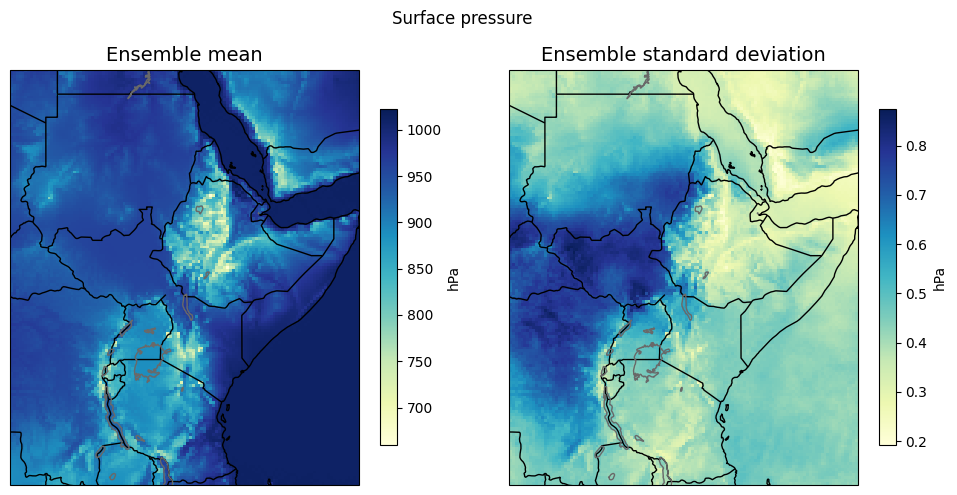

In [7]:
from cgan_ui.ecmwf_esm_viz import plot_forecast

# Plot the current data
plot_forecast(data)

In [8]:
import shutil
import tarfile
from loguru import logger
from pathlib import Path
from cgan_ui.constants import LEAD_START_HOUR, LEAD_END_HOUR

download = mr.Button(label="Download Data")

# prepare data downloads on button click
if download.clicked:
    # output_dir will be current directory when running in the Jupyter Notebook
    # output_dir will be some temporary directory path when running in Mercury
    output_dir = mr.OutputDir()
    d = init_date
    file_ext = "nc"
    forecast_hours = (
        [LEAD_START_HOUR, LEAD_END_HOUR]
        if DATA_PARAMS[vis_param.value]["accumulated"]
        else range(LEAD_START_HOUR, LEAD_END_HOUR + 1, 3)
    )
    # Just need the start and end lead times for accumulated variables
    for lead_hour in forecast_hours:
        # Name of the file we will read
        file_name = (
            f"{d.year}{d.month:02}{d.day:02}000000-{lead_hour}h-enfo-ef.{file_ext}"
        )
        # copy files to output dir
        ds_path = data_dir / file_name
        output_file = Path(output_dir.path) / f"{mask.value.lower()}-{file_name}"
        try:
            shutil.copy(ds_path, output_file)
        except Exception as err:
            logger.error(f"failed to copy {file_name} to output directory")


mercury.Button